In [146]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import cv2

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets as dset, transforms as T
from torchvision.utils import make_grid
from IPython.display import HTML


In [147]:
MANUAL_SEED = 42

torch.manual_seed(MANUAL_SEED)
print(f'Random Seed: {MANUAL_SEED}')

Random Seed: 42


In [211]:
data_color_root = 'C:/Datasets/Celeba/sample'
data_grayscale_root = 'C:/Datasets/Celeba/grayscale'
workers = 0 
batch_size = 10
image_size = (512, 288)
nc = 3
ngf = 64            # Number of features depth propagate through the generator,
ndf = 64            # Number of features depth propagate through the discriminator.
num_epochs = 10
lr = 0.0002
beta1 = 0.5         # beta1 hyperparameter for Adam optimizer.
ngpu = 1            # Number of GPUs.

In [212]:
is_cuda_available = torch.cuda.is_available()

device = torch.device('cuda:0' if is_cuda_available and ngpu > 0 else 'cpu')
device

device(type='cuda', index=0)

## Data for Train the Generator and Discriminator

In [213]:
class ImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2LAB, transform=T.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]
            imgs = [np.uint8(img) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs
        

In [214]:
tf_rgb = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

tf_gray = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=[.5], std=[.5])
])

tf_ab = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=[.5, .5], std=[.5, .5])
])

print(tf_rgb, tf_gray, tf_ab, sep='\n\n')

Compose(
    ToPILImage()
    Resize(size=(512, 288), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

Compose(
    ToPILImage()
    Resize(size=(512, 288), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

Compose(
    ToPILImage()
    Resize(size=(512, 288), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.5, 0.5], std=[0.5, 0.5])
)


In [217]:
# Load grayscale dataset.
gray_dataset = ImageDataset(path=data_grayscale_root, code=cv2.COLOR_BGR2GRAY, transform=tf_gray)
# Load color images with RGB color space.
rgb_dataset = ImageDataset(path=data_color_root, code=cv2.COLOR_BGR2RGB, transform=tf_rgb)
# Load LAB color space images.
lab_dataset = ImageDataset(path=data_color_root, code=cv2.COLOR_BGR2LAB, transform=tf_rgb)

In [ ]:
gray_loader = DataLoader(dataset=gray_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)
rgb_loader = DataLoader(dataset=rgb_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)
lab_loader = DataLoader(dataset=lab_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)
l_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)

In [ ]:
FIG_SIZE = (16, 15)

gray_batch1 = next(iter(gray_loader))
rgb_batch1 = next(iter(rgb_loader))
lab_batch1 = next(iter(lab_loader))
l_batch1 = next(iter(l_loader))

im_gray = make_grid(gray_batch1, nrow=10, normalize=True)
im_rgb = make_grid(rgb_batch1, nrow=10, normalize=True)
im_lab = make_grid(lab_batch1, nrow=10, normalize=True)
im_l = make_grid(l_batch1, nrow=10, normalize=True)

plt.figure(figsize=FIG_SIZE)

# Original grayscale images grid.
plt.subplot(411)
plt.imshow(np.transpose(im_gray, axes=(1, 2, 0)))
plt.title('ORIGINA: GRAYSCALE SAMPLE')

# Original RGB images grid.
plt.subplot(412)
plt.imshow(np.transpose(im_rgb, axes=(1, 2, 0)))
plt.title('ORIGINAL RGB COLOR SPACE SAMPLE')

# L color channel of LAB color space.
plt.subplot(413)
plt.imshow(np.transpose(im_l, axes=(1, 2, 0)))
plt.title('"L" COLOR CHANNEL OF LAB SAMPLE')

# AB color channels of LAB color space.
plt.subplot(414)
plt.imshow(np.transpose(im_lab, axes=(1, 2, 0)))
plt.title('"LAB" COLOR CHANNELS OF LAB SAMPLE')


## Weight Initialization for the Layer of Both of the Discriminator and Generator Models

In [165]:
def weight_init(m):

    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean=0., std=0.2)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, mean=1., std=0.2)
        nn.init.constant_(m.bias.data, val=0.)
        

In [201]:
class Generator(nn.Module):

    def __init__(self, nz=1):
        super(Generator, self).__init__()

        self.ngpu = ngpu
        self.encode = nn.Sequential(
            # Input is 1 x 512 x 288, going into convolution.
            nn.Conv2d(in_channels=nz, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            # State size => (ngf) x 256 x 144
            nn.Conv2d(in_channels=ngf, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # State size (ngf * 2) x 128 x 72
            nn.Conv2d(in_channels=ngf * 2, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            # State size (ngf * 4) x 64 x 36
            nn.Conv2d(in_channels=ngf * 4, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # State size (ngf * 8) x 32 x 18
            nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(inplace=True),
            # State size (ngf * 16) x 16 x 9
        )
        self.decode = nn.Sequential(
            # Input is 'ngf * 16', going into convolution.
            nn.ConvTranspose2d(in_channels=ngf * 16, out_channels=ngf * 8, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ngf * 8) x 18 * 32
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ngf * 4) x 36 x 64
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ngf * 2) x 72 x 128
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ngf) x 144 x 256
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=2, stride=2, bias=False),
            nn.Tanh()
            # State size => (nc) x 288 x 512
        )

    def forward(self, X):
        X = self.encode(X)
        return self.decode(X)


# Create the generator(G) model instance.
netG = Generator().to(device)
netG.apply(weight_init)


Generator(
  (encode): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  )
  (decode): Se

torch.Size([10, 3, 512, 288])


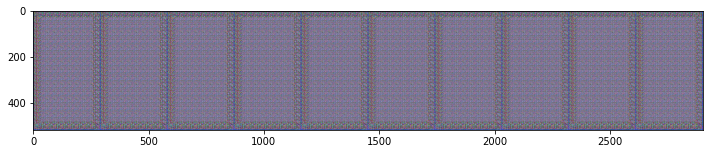

In [202]:
X = torch.ones(10, 1, 512, 288, device=device)

y = netG(X)
print(y.shape)

im = make_grid(y.detach().cpu(), nrow=10, normalize=True)
im = np.transpose(im.numpy() * 255, axes=(1, 2, 0)).astype(np.uint8)

plt.figure(figsize=(12, 11))
plt.imshow(cv2.cvtColor(im, code=cv2.COLOR_LAB2RGB))

In [203]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is (nc) x 512 x 288
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf) x 256 x 144
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 2) x 128 x 72
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 4) x 64 x 36
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 8) x 32 x 18
            nn.Conv2d(in_channels=ndf * 8, out_channels=ndf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 16) x 16 x 9
            nn.Conv2d(in_channels=ndf * 16, out_channels=1, kernel_size=(16, 9), stride=2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Create discriminator(D) model instance.
netD = Discriminator().to(device)
netD.apply(weight_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1024, kernel_siz

In [204]:
# Enable parallel process over GPUs, if desired (When ngpu == 1, do not occur parallel execution, since there is only one GPU);
if device.type == 'cuda' and ngpu >= 1:
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

print(netG, netD, sep='\n\n')

DataParallel(
  (module): Generator(
    (encode): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (12): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## Loss Function and Optimizers

In [205]:
# Initializing "Binary Cross Entropy" loss function.
criterion = nn.BCELoss().to(device)

# Initializing "Adam" optimizers for both G and D networks.
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [206]:
# Establish convention for the real and fake images during training.
real_labels = 1
fake_labels = 0

## Training

In [207]:
img_list = []
G_losses = []
D_losses = []

iters = 0

print("Starting training loop...")

start = time.time()

for epoch in range(num_epochs):
    epoch += 1

    for batch, (lab_images, l_images) in enumerate(zip(lab_loader, l_loader), 0):
        batch += 1

        # ###################################################################
        # Train the D network. Maximize the ability to classify real and fake 
        # images.
        # ###################################################################

        ############## Train with all real image batch ######################
        netD.zero_grad()
        # Create label batch to check the loss with real images.
        lab_images.to(device)
        l_images.to(device)

        batch_size = lab_images.shape[0]
        labels = torch.full(size=(batch_size, ), fill_value=real_labels, dtype=torch.float32, device=device)

        # Feed forward real batch through D.
        y = netD(lab_images).view(-1)
        # Loss calculation on all real batch.
        errD_real = criterion(y, labels)

        # Calculate the gradient for the D in back-propagation.
        errD_real.backward()
        D_x = y.mean().item()

        ############ Train with all grayscale image batch ###################

        # Generate fake image batch with G.
        fake = netG(l_images)
        labels.fill_(fake_labels)

        # Classify all fake image images with D. 'detach()' the 'fake' to avoid leaking G gradient to D.
        y = netD(fake.detach()).view(-1)

        # Calculate D loss for all fake images.
        errD_fake = criterion(y, labels)

        # Calculate the the gradient for fake batch in back-propagation.
        errD_fake.backward()
        D_G_z1 = y.mean().item()

        # Calculate total gradient to real and fake images for D.
        errD = errD_real + errD_fake

        # Update D.
        optimizerD.step()

        # ###################################################################
        # Train the G network. Minimize the ability of creating fake images.
        # ###################################################################

        netG.zero_grad()

        labels.fill_(real_labels) # Fake images are real of G's perspective.

        # Since we just updated the D, feed forward the batch of fake images 
        # without 'detach()' the gradient from the G. So, we could literally 
        # discriminate the G's previous output.
        y = netD(fake).view(-1)

        # Calculate G's loss base off this output.
        errG = criterion(y, labels)

        # Calculate gradient for the G.
        errG.backward()
        D_G_z2 = errG.mean().item()

        # Update generator.
        optimizerG.step()

        # OUTPUT TRAINING STATS.
        if batch == 1 or batch % 100 == 0:
            print("[{}/{}] [{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f}/{:.4f}"
                .format(epoch, num_epochs, batch, len(lab_loader), errD, errG, D_x, D_G_z1, D_G_z2))
            
        D_losses.append(errD)
        G_losses.append(errG)

        # Check how the G is doing by saving the G's output on fixed noise.
        if iters % 500 == 0 or ((epoch == num_epochs) and (batch == len(l_loader))):
            with torch.no_grad():
                fake = netG(l_images).detach().cpu()
            
            img_list.append(make_grid(fake, nrow=10, normalize=True))

        iters += 1


duration = time.time() - start
print(f"Execution Duration: {duration / 60:0.4f} minutes")

Starting training loop...
[1/10] [1/1]	Loss_D: 37.2604	Loss_G: 31.2773	D(x): 0.3403	D(G(z)): 0.0000/31.2773
[2/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
[3/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
[4/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
[5/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
[6/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
[7/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
[8/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
[9/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
[10/10] [1/1]	Loss_D: 150.0000	Loss_G: 0.0000	D(x): 0.5000	D(G(z)): 1.0000/0.0000
Execution Duration: 0.0522 minutes


In [ ]:
plt.figure(figsize=(10, 9))
plt.title('GENERATOR(G) AND DISCRIMINATOR(D) LOSS OVER THE EPOCHS')
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [209]:
def lab_to_rgb(im):

    if str(type(im)).find('torch') != -1:
        im = im.numpy() * 255

    if len(im.shape) == 3 and im.shape[2] > 3:
        im = np.transpose(im, (1, 2, 0)).astype(np.uint8)

    return cv2.cvtColor(im, code=cv2.COLOR_LAB2RGB)

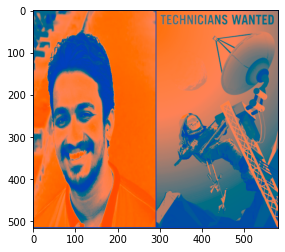

In [210]:
color = lab_to_rgb(im_l)

plt.imshow(color)